In [156]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingRegressor,AdaBoostRegressor
from xgboost import XGBRegressor



In [ ]:
shutil.unpack_archive('/content/parkinsons+telemonitoring.zip')

In [ ]:
df = pd.read_csv('/content/parkinsons_updrs.data')

In [ ]:
df.head()

,subject#,age,sex,test_time,motor_UPDRS,total_UPDRS,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE
0,1,72,0,5.6431,28.199,34.398,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006
1,1,72,0,12.6660,28.447,34.894,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810
2,1,72,0,19.6810,28.695,35.389,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014
3,1,72,0,25.6470,28.905,35.810,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277
4,1,72,0,33.6420,29.187,36.375,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361


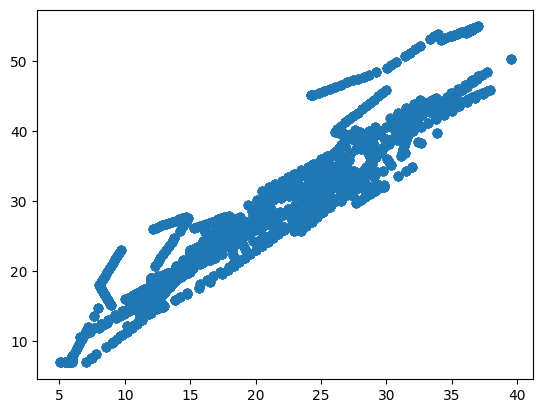

In [ ]:
plt.scatter(df['motor_UPDRS'],df['total_UPDRS'])

In [148]:
X = df.drop(['subject#','motor_UPDRS','total_UPDRS'],axis=1)
y = df['motor_UPDRS']

In [153]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## testing models with default parameters

In [157]:
models = {
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    "XGBoost": XGBRegressor(),
    "Gradient Boosting": GradientBoostingRegressor(),
    "AdaBoost": AdaBoostRegressor(),
    'SVM': SVR()
}

In [158]:
for model_name,model in models.items():
  scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')

  print(f"{model_name} MSE: {-scores.mean()}")




Decision Tree MSE: 6.885484567170212
Random Forest MSE: 2.3491215649833483
XGBoost MSE: 3.333294260776328
Gradient Boosting MSE: 15.796646959774097
AdaBoost MSE: 39.848794628863075
SVM MSE: 61.14018864660911


==> random forest has the lower mean square errors



In [167]:
def evaluate_model(  model,X_test,y_test):
  ypred = model.predict(X_test)
  mse = mean_squared_error(y_test, ypred)
  rmse = mse ** 0.5
  r2 = r2_score(y_test, ypred)
  print("MSE:", mse)
  print("RMSE:", rmse)
  print("R² Score:", r2)


In [170]:
def plot(ytest,ypred):
  plt.scatter(y_test, ypred, alpha=0.3)
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red')
  plt.xlabel("Actual")
  plt.ylabel("Predicted")
  plt.title("Actual vs Predicted")
  plt.grid(True)
  plt.show()


## using random Forest with default parameters

In [169]:
model = RandomForestRegressor()
model.fit(X_train, y_train)
evaluate_model(model,X_test,y_test)

MSE: 1.7100036546092874
RMSE: 1.3076710804362415
R² Score: 0.9732097071347134


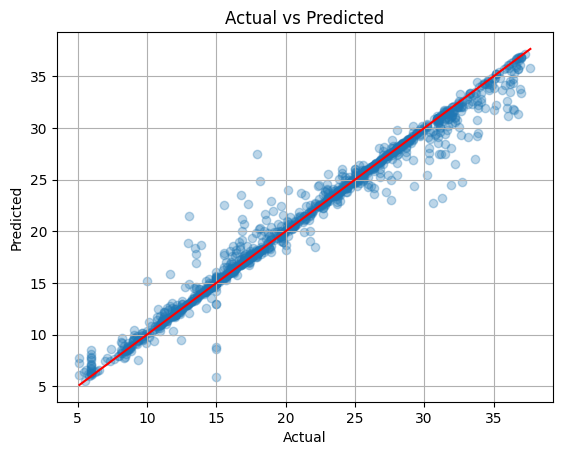

In [172]:
ypred_model=model.predict(X_test)
plot(y_test,ypred_model)

In [171]:
def plot_residuals(y_test,ypred):
  residuals = y_test - ypred

  sns.scatterplot(x=ypred, y=residuals)
  plt.axhline(0, color='red', linestyle='--')
  plt.xlabel('Predicted values')
  plt.ylabel('Residuals')
  plt.title('Residuals vs Predicted')
  plt.show()


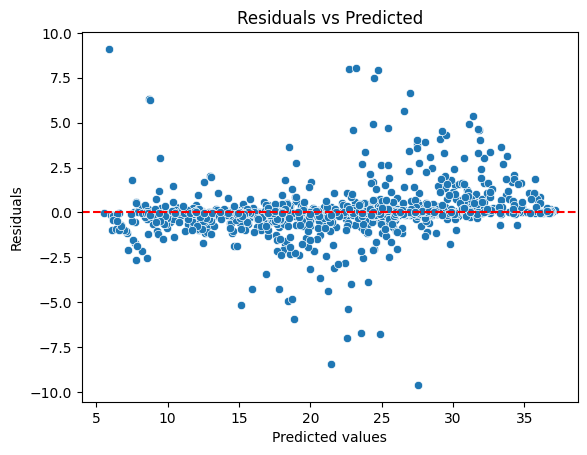

In [173]:
plot_residuals(y_test,ypred_model)

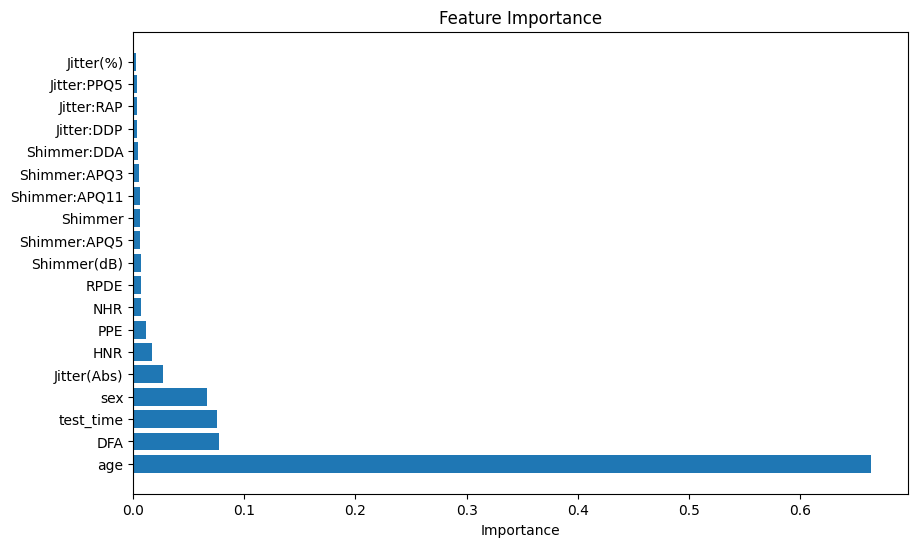

In [164]:
importances = model.feature_importances_

feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

===> features that the model thinks are important

## Customize Random Forest

In [166]:
param_grid = {
    'n_estimators': [50, 100, 200,300],
    'max_depth': [None, 10, 20, 30],
}

grid_search = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'n_estimators': [50, 100, 200, 300]},
             verbose=2)

In [168]:
print(f"Best Parameters: {grid_search.best_params_}")
print(f"Best Cross-Validation Score: {grid_search.best_score_}")

Best Parameters: {'max_depth': 20, 'n_estimators': 300}
Best Cross-Validation Score: 0.9658894861208525


## evaluate the best model

In [174]:
best_model = grid_search.best_estimator_


In [176]:
y_pred_best=best_model.predict(X_test)

In [179]:
evaluate_model(best_model,X_test,y_test)

MSE: 1.6617502710402534
RMSE: 1.2890889306173774
R² Score: 0.9739656834591329


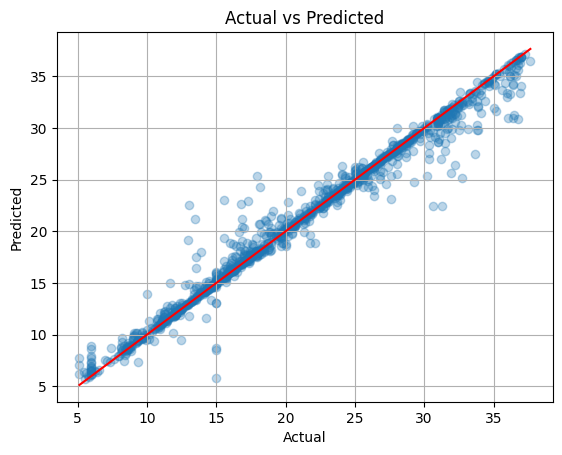

In [177]:
plot(y_test,y_pred_best)

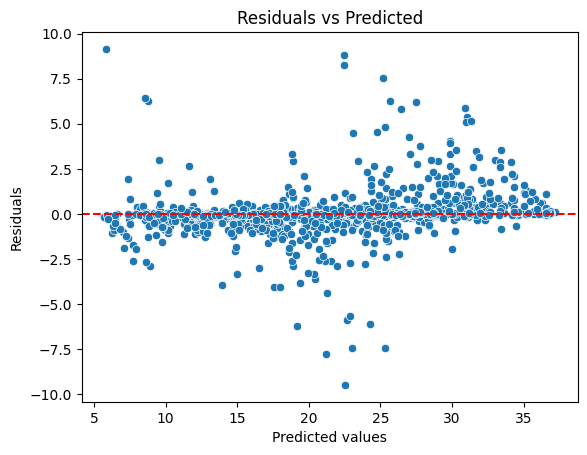

In [195]:
plot_residuals(y_test,y_pred_best)

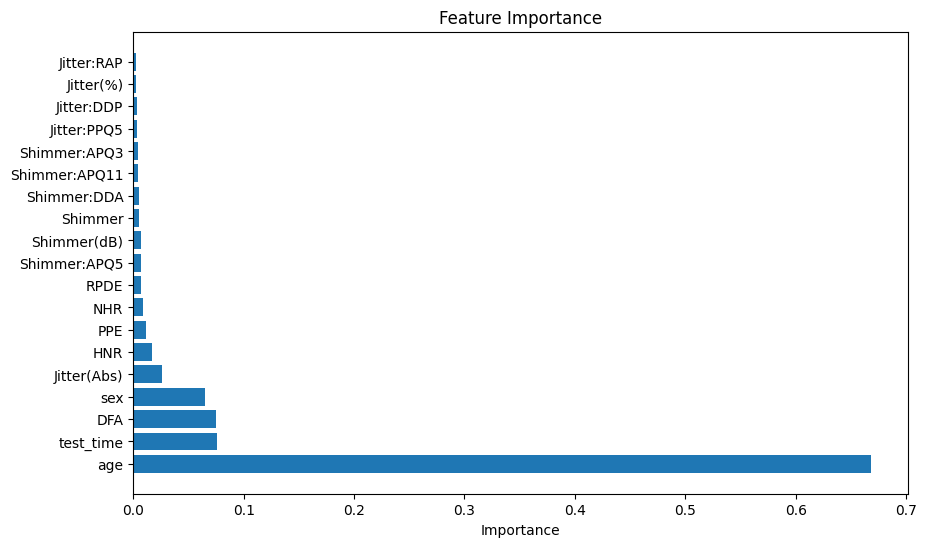

In [178]:
importances = best_model.feature_importances_

feature_names = X_train.columns
feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()

====> Extract the important features from the dataset

In [182]:
important_features=feature_importance_df['Feature'].to_list()[:-6]

In [183]:
X_train_important=X_train[important_features]
X_test_important=X_test[important_features]

In [184]:
best_model.fit(X_train_important, y_train)

RandomForestRegressor(max_depth=20, n_estimators=300, random_state=42)

In [185]:
best_model.score(X_test_important,y_test)

0.9740242389950934

In [186]:
evaluate_model(best_model,X_test_important,y_test)

MSE: 1.65801271650908
RMSE: 1.2876384261542835
R² Score: 0.9740242389950934


In [193]:
ypred_best_important=best_model.predict(X_test_important)

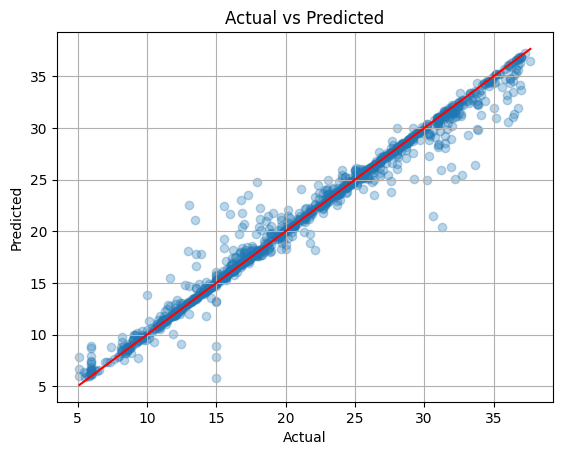

In [194]:
plot(y_test,ypred_best_important)

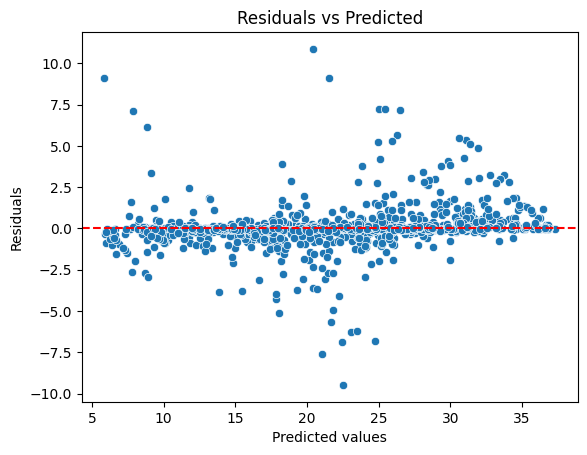

In [196]:
plot_residuals(y_test,ypred_best_important)

In [197]:
result={
    "best model":"Random Forest",
    "best parameters":grid_search.best_params_,
    "important features":important_features,
    "target":"motor_UPDRS",
    "mse":1.65801271,
    "rmse":1.28763842,
    "R²":0.97402423
}

In [198]:
result

{'best model': 'Random Forest',
 'best parameters': {'max_depth': 20, 'n_estimators': 300},
 'important features': ['age',
  'test_time',
  'DFA',
  'sex',
  'Jitter(Abs)',
  'HNR',
  'PPE',
  'NHR',
  'RPDE',
  'Shimmer:APQ5',
  'Shimmer(dB)',
  'Shimmer',
  'Shimmer:DDA'],
 'target': 'motor_UPDRS',
 'mse': 1.65801271,
 'rmse': 1.28763842,
 'R²': 0.97402423}

In [202]:
import json
with open('result.json', 'w') as file:
    json.dump(result, file,indent=3)




In [203]:
import pickle
with open('model.pkl', 'wb') as file:
    pickle.dump(best_model, file)